In [4]:
"""Import modules"""
import os
import typing
import warnings
import itertools
import geopandas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")


class Agros:
    """
    Class designed to illustrate data from the Our World in Data
    agricultural dataset, based on countries. Country names from agricultural
    data should be used.

    @Class attributes
    data: pandas dataframe
        Pandas DataFrame containing all data from the csv file
    geodata: geopandas dataframe
        Geopandas dataframe from shapefile
    all_data: geopandas dataframe
        geopandas dataframe containing all information from dataset

    @Private class attributes
    _url: str
        String link to csv data
    _geourl: str
        String to naturalearth dataset
    _merge_dict: dictionary
        mapping of countries to rename in Geodata.csv
    _exclude: list:str
        Countries to exclude from aggregation

    @Public methods
    download_data(None) -> None
        Gets data from agricultural and vector database
    countries_list(None) -> list
        Returns all unique countries in dataset
    variable_correlation(None) -> None
        Plots correlation between all countries
    area_chart(country: str, normalize: bool) -> None
        Plots data from all ouput columns for selected country
    total_output_country(*country: str) -> None
        Plots total agricultural ouput from selected countries
    gapminder(year: int) -> None
        Plots the output quantity based on the fertilizer quantity
    cloropleth(year: int) -> None
        Plots tfp column on chloropleth on a given year
    arima_grid_search(self, data: list) -> typing.Tuple
        Gives best ARIMA parameters to predictor
    predictor( *countries: str, seasonal: bool = True) -> None
        Generate a plot of predicted TFP values for the specified countries.
    """

    def __init__(self) -> None:
        """
        Initialize Agros class with data

        @params
        None

        @Returns
        None

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        Natural Earth: 1:110m cultural data
        """

        self._geourl = "naturalearth_lowres"

        self._url = (
            "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/"
            "Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total"
            "%20factor%20productivity%20(USDA).csv?=raw=true"
        )

        self._merge_dict = {
            "United States of America": "United States",
            "Dem. Rep. Congo": "Democratic Republic of Congo",
            "Central African Rep.": "Central African Republic",
            "S. Sudan": "South Sudan",
        }

        self._exclude = [
            "World",
            "Western Europe",
            "West Asia",
            "West Africa",
            "Upper-middle income",
            "Sub-Saharan Africa",
            "Southeast Asia",
            "Southern Africa",
            "Southern Europe",
            "South Africa",
            "South Asia",
            "Northeast Asia",
            "Northern Europe",
            "North Africa",
            "North America",
            "Low income",
            "Lower-middle income",
            "Least developed countries",
            "Latin America and the Caribbean",
            "Horn of Africa",
            "High Income",
            "Former Soviet Union",
            "Europe",
            "East Africa",
            "Eastern Europe",
            "Developed Asia",
            "Developed countries",
            "Caribbean",
            "Central Africa",
            "Central African Republic",
            "Oceania",
            "Micronesia",
            "Central America",
            "Central Asia",
            "Central Europe",
            "Asia",
            "High income",
            "Pacific",
        ]

    def download_data(self) -> None:
        """
        Method gets data to class, either reading it from file, or downloading file.
        If both fail the method returns empty dataframe.

        @params
        None

        @Returns
        None

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        Natural Earth: 1:110m cultural data
        """

        # Set file path (. for notebooks and .. for python3)
        file_path_base = "../downloads/"
        file_path_agriculture = "../downloads/Data.csv"
        file_path_geographical = "../downloads/Geodata.shp"

        # Create downloads folder if it does not exist
        if not os.path.exists(file_path_base):
            print(f'Setting up folder {file_path_base}')
            os.mkdir(file_path_base)

        # Read or download agricultural data
        if os.path.exists(file_path_agriculture):
            print(f'Reading agricultural data from {file_path_agriculture}')
            self.data = pd.read_csv(file_path_agriculture)
        else:
            self.data = pd.read_csv(self._url)
            print(f'Downloading and saving agricultural data to {file_path_agriculture}')
            self.data.to_csv(file_path_agriculture, encoding="utf-8")

        # Read or download geographical data
        if os.path.exists(file_path_geographical):
            print(f'Reading geodata data from {file_path_geographical}')
            self.geodata = geopandas.read_file(file_path_geographical)
        else:
            self.geodata = geopandas.read_file(
                geopandas.datasets.get_path(self._geourl)
            )
            print(f'Downloading and saving geodata to {file_path_geographical}')
            self.geodata.to_file(file_path_geographical)

        # Rename countries in geodata to conform to agricultural data
        geodata_renamed = self.geodata.copy()
        geodata_renamed["name"].replace(self._merge_dict, inplace=True)
        # Merge data on countries
        self.all_data = geodata_renamed.rename(columns={"name": "Entity"}).merge(
            self.data, on="Entity"
        )

        print('All files read successfully')

    def total_output_country(self, *country: str) -> None:
        """
        This method compars the total of the "_output_" columns for countries and plot it.
        Only input one of the parameters, single string will be transformed to list.

        @params
        country: String with country name or countries separated by commas

        @Returns
        None

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        """

        # Ensure a value is given
        if not country:
            raise KeyError("Please input one country or more")

        # Get list of all countries
        all_countries = self.countries_list()

        # Check given parameters are in data
        for value in country:
            if value not in all_countries:
                raise TypeError(f"Country {value} not found in data")

        # Set columns to keep in data for summary
        target_columns = [
            "Entity",
            "Year",
            "crop_output_quantity",
            "animal_output_quantity",
            "fish_output_quantity",
        ]

        # Fetch relevant data based on countries
        relevant_data = self.data[self.data["Entity"].isin(country)][target_columns]

        # Find total output based on relevant columns
        relevant_data["total_output"] = relevant_data[
            ["crop_output_quantity", "animal_output_quantity", "fish_output_quantity"]
        ].sum(axis=1)

        # Create pivot table to easily plot data
        result = (
            relevant_data[["Year", "Entity", "total_output"]]
            .pivot_table(index="Year", columns="Entity", values="total_output")
            .reset_index()
        )

        # Get all countries in string
        title_header = ", ".join(country)
        # Plot data
        result.plot.line(x="Year", title=f"Total output per year {title_header}")
        plt.annotate(
            text="Source: Our World in Data, Feb 1, 2022",
            xy=(1, 1),
            xycoords="figure points",
        )
        plt.tight_layout()
        plt.show()

    def countries_list(self) -> list:
        """
        Method that outputs a list of countries available in the data.

        @params
        None

        @Returns
        countries: List of unique countries in the data

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        """

        countries = list(dict.fromkeys(self.data["Entity"]))
        countries = [i for i in countries if i not in self._exclude]
        return countries

    def variable_correlation(self) -> None:
        """
        This function takes the data and plots a heatmap,
        that shows the correlation between the "_quantity" columns.

        @params
        None

        @Returns
        None

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        """
        # Extract the "_quantity" columns
        quantity_columns = self.data.filter(regex="_quantity$")

        # Calculate the correlation matrix
        corr_matrix = quantity_columns.corr()
        
        # Masking the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Plot the heatmap
        sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True)
        plt.annotate(
            text="Source: Our World in Data, Feb 1, 2022",
            xy=(1, 1),
            xycoords="figure points",
        )
        plt.tight_layout()
        plt.show()

In [5]:
test = Agros()

In [7]:
test.variable_correlation()

AttributeError: 'Agros' object has no attribute 'data'

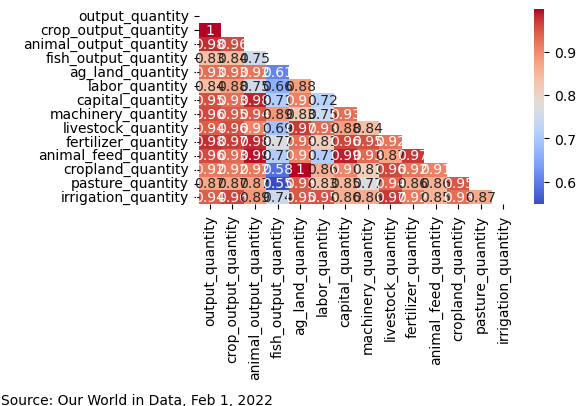

In [24]:
data = pd.read_csv("../downloads/Data.csv")


def variable_correlation() -> None:
        """
        This function takes the data and plots a heatmap,
        that shows the correlation between the "_quantity" columns.

        @params
        None

        @Returns
        None

        @Source
        Our World in Data: Agricultural total factor productivity (USDA)
        """
        # Extract the "_quantity" columns
        quantity_columns = data.filter(regex="_quantity$")

        # Calculate the correlation matrix
        corr_matrix = quantity_columns.corr()
        
        # Masking the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Plot the heatmap
        plt.figure(dpi=100)
        sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True)
        plt.annotate(
            text="Source: Our World in Data, Feb 1, 2022",
            xy=(1, 1),
            xycoords="figure points",
        )
        plt.tight_layout()
        plt.show()
        
        
variable_correlation()